In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import numpy as np
import math

In [102]:
# U-Net Model Definition
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        def up_conv(in_channels, out_channels):
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

        self.down1 = conv_block(1, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up4 = up_conv(1024, 512)
        self.conv4 = conv_block(1024, 512)
        self.up3 = up_conv(512, 256)
        self.conv3 = conv_block(512, 256)
        self.up2 = up_conv(256, 128)
        self.conv2 = conv_block(256, 128)
        self.up1 = up_conv(128, 64)
        self.conv1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)
        d3 = self.down3(p2)
        p3 = self.pool3(d3)
        d4 = self.down4(p3)
        p4 = self.pool4(d4)

        b = self.bottleneck(p4)

        u4 = self.up4(b)
        c4 = self.conv4(torch.cat([u4, d4], dim=1))
        u3 = self.up3(c4)
        c3 = self.conv3(torch.cat([u3, d3], dim=1))
        u2 = self.up2(c3)
        c2 = self.conv2(torch.cat([u2, d2], dim=1))
        u1 = self.up1(c2)
        c1 = self.conv1(torch.cat([u1, d1], dim=1))
        return self.final(c1)

In [103]:
# Blurring Function
def gaussian_blur(image, sigma):
    image = np.array(image)
    blurred = gaussian_filter(image, sigma=sigma)
    return TF.to_tensor(blurred)

# PSNR Calculation
def calculate_psnr(target, prediction):
    mse = nn.functional.mse_loss(prediction, target, reduction='mean').item()
    if mse == 0:
        return float('inf')
    psnr = 20 * math.log10(1.0 / math.sqrt(mse))
    return psnr

In [104]:
# Data Preparation
transform_train = transforms.Compose([
    transforms.Pad((2,2,2,2)),
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.Pad((2,2,2,2)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [105]:
for inputs, _ in train_loader:
  print(inputs.shape)
  inputs = inputs.permute(0,1,3,2)
  print(inputs.shape)
  break

torch.Size([32, 1, 32, 32])
torch.Size([32, 1, 32, 32])


In [106]:
h1_sigma = 1
h2_sigma = 0.5

In [107]:
[print(i,'\n') for i in np.ones((2,2))]

[1. 1.] 

[1. 1.] 



[None, None]

In [108]:
# Training Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training Loop
epochs = 5
tolerance = 0.05
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    total_psnr_train = 0.0
    for inputs, _ in train_loader:
        # inputs = inputs.permute(0,2,1,3)
        inputs = inputs.to(device)
        targets = inputs.clone()  # The target is the original sharp image

        inputs = inputs.cpu()
        inputs = torch.stack([gaussian_blur(input, sigma = h1_sigma) for input in inputs])
        inputs = inputs.to(device)
        inputs = inputs.permute(0,2,1,3)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        correct_train += torch.sum(torch.abs(outputs - targets) < tolerance).item()
        total_train += torch.numel(targets)

        # Calculate PSNR for mini-batch
        psnr = calculate_psnr(targets, outputs)
        total_psnr_train += psnr
        print(f"Mini-batch PSNR: {psnr:.4f}")

    train_accuracy = correct_train / total_train
    avg_psnr_train = total_psnr_train / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, Avg Train PSNR: {avg_psnr_train:.4f}")

    # Calculate test loss, accuracy, and PSNR after every epoch
    model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    total_psnr_test = 0.0
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device)
            targets = inputs.clone()  # The target is the original sharp image

            inputs = inputs.cpu()
            inputs = torch.stack([gaussian_blur(input, sigma = h2_sigma) for input in inputs])
            inputs = inputs.to(device)
            inputs = inputs.permute(0,2,1,3)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item()

            # Calculate test accuracy
            correct_test += torch.sum(torch.abs(outputs - targets) < tolerance).item()
            total_test += torch.numel(targets)

            # Calculate PSNR for mini-batch
            psnr = calculate_psnr(targets, outputs)
            total_psnr_test += psnr

    test_accuracy = correct_test / total_test
    avg_psnr_test = total_psnr_test / len(test_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.4f}, Avg Test PSNR: {avg_psnr_test:.4f}")

Streaming output truncated to the last 5000 lines.
Mini-batch PSNR: 29.9176
Mini-batch PSNR: 30.2856
Mini-batch PSNR: 29.4669
Mini-batch PSNR: 29.7478
Mini-batch PSNR: 29.3533
Mini-batch PSNR: 29.0599
Mini-batch PSNR: 28.8224
Mini-batch PSNR: 29.7521
Mini-batch PSNR: 28.8153
Mini-batch PSNR: 29.0038
Mini-batch PSNR: 28.9034
Mini-batch PSNR: 28.9980
Mini-batch PSNR: 29.0984
Mini-batch PSNR: 29.4023
Mini-batch PSNR: 29.3344
Mini-batch PSNR: 29.6071
Mini-batch PSNR: 29.3145
Mini-batch PSNR: 29.5842
Mini-batch PSNR: 29.0551
Mini-batch PSNR: 29.3096
Mini-batch PSNR: 29.3794
Mini-batch PSNR: 28.8491
Mini-batch PSNR: 29.0200
Mini-batch PSNR: 29.6589
Mini-batch PSNR: 29.2380
Mini-batch PSNR: 30.0086
Mini-batch PSNR: 30.1246
Mini-batch PSNR: 29.4229
Mini-batch PSNR: 30.0561
Mini-batch PSNR: 29.5903
Mini-batch PSNR: 29.1712
Mini-batch PSNR: 29.2065
Mini-batch PSNR: 29.1504
Mini-batch PSNR: 29.1041
Mini-batch PSNR: 29.5761
Mini-batch PSNR: 28.5241
Mini-batch PSNR: 29.4671
Mini-batch PSNR: 28.8072

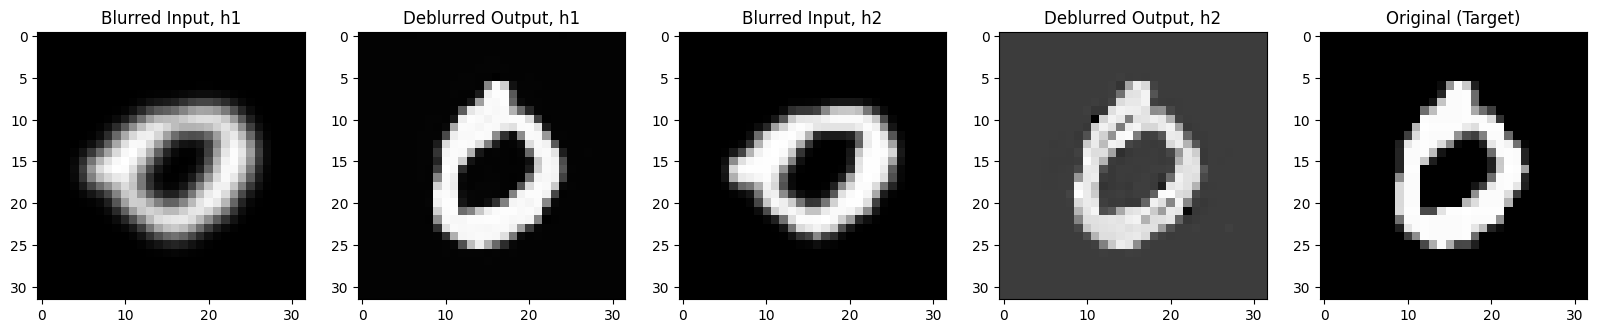

In [109]:
# Testing Loop
model.eval()
with torch.no_grad():
    for inputs, _ in test_loader:
        # inputs=inputs.permute(0,2,1,3)
        inputs = inputs.to(device)
        targets = inputs.clone()  # The target is the original sharp image

        inputs = inputs.cpu()
        inputs_h1 = torch.stack([gaussian_blur(input, sigma = h1_sigma) for input in inputs])
        inputs_h2 = torch.stack([gaussian_blur(input, sigma = h2_sigma) for input in inputs])
        inputs_h1 = inputs_h1.to(device)
        inputs_h2 = inputs_h2.to(device)
        inputs_h1 = inputs_h1.permute(0,2,1,3)
        inputs_h2 = inputs_h2.permute(0,2,1,3)

        outputs_h1 = model(inputs_h1)
        outputs_h2 = model(inputs_h2)
        # Displaying a few examples
        k=3
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        axes[0].imshow(inputs_h1[k].cpu().squeeze(), cmap='gray')
        axes[0].set_title('Blurred Input, h1')
        axes[1].imshow(outputs_h1[k].cpu().squeeze(), cmap='gray')
        axes[1].set_title('Deblurred Output, h1')
        axes[2].imshow(inputs_h2[k].cpu().squeeze(), cmap='gray')
        axes[2].set_title('Blurred Input, h2')
        axes[3].imshow(outputs_h2[k].cpu().squeeze(), cmap='gray')
        axes[3].set_title('Deblurred Output, h2')
        axes[4].imshow(targets[k].cpu().squeeze(), cmap='gray')
        axes[4].set_title('Original (Target)')
        plt.show()
        break

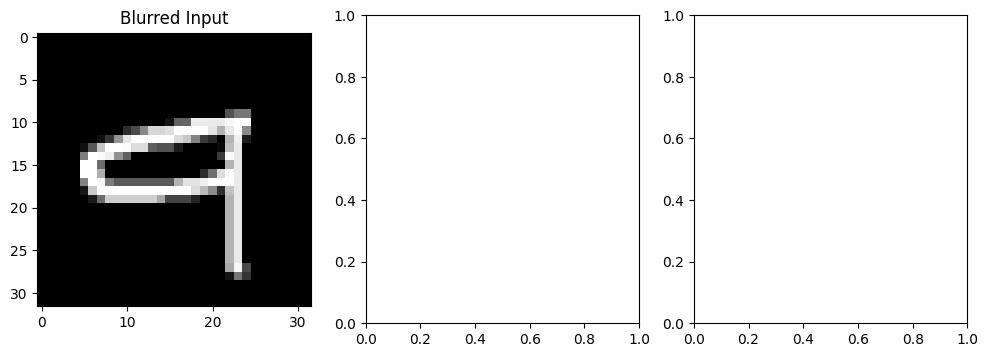

In [110]:
# model.eval()
# with torch.no_grad():
for inputs, _ in train_loader:
    inputs = inputs.permute(0,2,1,3)
    inputs = inputs.to(device)
    # outputs = model(inputs)

    # Displaying a few examples
    k=3
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(inputs[k].cpu().squeeze(), cmap='gray')
    axes[0].set_title('Blurred Input')
    # axes[1].imshow(outputs[k].cpu().squeeze(), cmap='gray')
    # axes[1].set_title('Deblurred Output')
    # axes[2].imshow(inputs[k].cpu().squeeze(), cmap='gray')
    # axes[2].set_title('Original (Target)')
    plt.show()
    break